In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat as loadmat
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

# Suppress warnings`
warnings.filterwarnings("ignore")

In [227]:
import imp
imp.reload(xy)

<module 'xy' from 'E:\\PyProject\\factors\\STR\\xy.py'>

In [2]:
import xy

# $因子描述：STR$

***凸显性***  
对于当日涨跌幅超过阈值的标的,赋予更高/更低的权重。

1. 数据：指数日K线  
2. 使用13日收益率均值/13日标准差,作为基础动量因子F
3. 当t日涨跌幅超过阈值(动态阈值,F的函数),则使用换手率代替F因子值

$参考报告：《20230323-广发证券-行为金融研究系列之七：凸显理论之A股价量应用》$

## 计算

In [60]:
def func2(arr):
    return np.nanmedian(np.argwhere(arr))

In [229]:
mean_ret = xy.index_volume.loc[['50','300','500','1000']].mean()

In [247]:
theta = 0.003

In [1879]:
sigma = xy.index_tov.loc[['50','300','500','1000']].copy().dropna(how='all',axis=1)
sign = xy.Index_rets.loc[['50','300','500','1000']].copy().dropna(how='all',axis=1)

### 如果|涨跌幅|大于阈值，则比较换手，否则比较夏普

<Axes: >

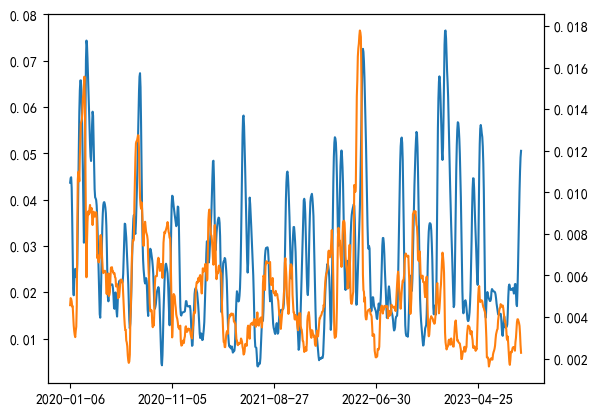

In [1849]:
(0.2*pd.DataFrame(_sign.rolling(5).mean()[::].T, index = sign.index, columns = sign.columns).T.rolling(15).std().dropna()).loc['2020-01-04':,'1000'].plot()
(pd.DataFrame(sign.T.rolling(1).mean().rolling(5).mean()[::].T, index = sign.index, columns = sign.columns).T.rolling(15).std().dropna()).loc['2020-01-04':,'1000'].plot(secondary_y=True)
# (0.19*pd.DataFrame(_sign.rolling(4).mean()[::].T, index = sign.index, columns = sign.columns).T.rolling(15).std().dropna()).loc['2020-01-04':,'1000'].plot()

In [1938]:
_sign = (sign.T.rolling(13).mean()/sign.T.rolling(13).std()).rolling(1).mean()
logi1 = sign>=0.2*pd.DataFrame(_sign.rolling(5).mean()[::].T, index = sign.index, columns = sign.columns).T.ffill().rolling(15).std().T
logi2 = sign<=-0.2*pd.DataFrame(_sign.rolling(5).mean()[::].T , index = sign.index, columns = sign.columns).T.ffill().rolling(15).std().T                             
_sigma = _sign.T.mask((logi2|logi1),  sigma.abs()).shift(1,axis=1)

In [1867]:
delta = 0.6

w = ((delta**_sigma.rank(ascending=False)/(delta**_sigma.rank(ascending=False) * 1/4).sum())*(1/4)).loc[:,'2016-01-04':]

STR = {}
for st in w.index:
    STR[st] = {}
    for col in w.columns[19:]:
        c = w.loc[st,:col].iloc[-20:].dropna().corr(sign.loc[st,:col].iloc[-20:].dropna())
        if np.isnan(c):
            STR[st][col] = 0
        else:
            STR[st][col] = c
    #     break
    # break

pd_STV = pd.DataFrame(STR).rolling(1).mean().shift().T.loc[:,'2016-01-04':]

<Axes: >

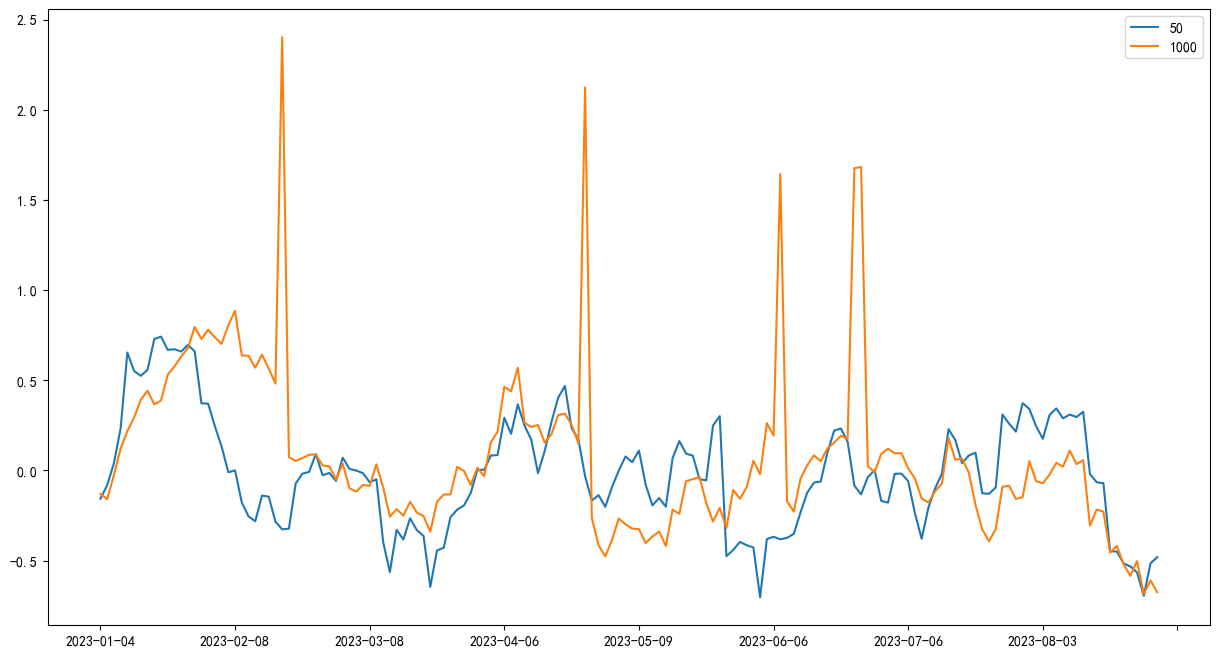

In [1913]:
_sigma.T.loc['2023-01-04':,['50','1000']].plot(figsize=(15,8))

In [1845]:
_sigma.T.rolling(1).mean().shift(0).T.loc[['50','1000'],'2016-01-04':]

,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,...,2023-08-15,2023-08-16,2023-08-17,2023-08-18,2023-08-21,2023-08-22,2023-08-23,2023-08-24,2023-08-25,2023-08-28
50,0.019449,-0.153890,-0.116115,-0.117821,-0.280325,-0.337066,-0.435968,-0.427390,-0.437675,-0.407267,...,-0.065581,-0.070386,-0.447730,-0.449795,-0.515527,-0.532085,-0.565365,-0.694982,-0.514560,-0.480746
1000,0.256998,-0.143034,-0.233410,-0.241236,-0.366062,-0.377044,-0.516900,-0.486033,-0.567701,-0.469242,...,-0.217022,-0.228422,-0.455435,-0.417831,-0.519944,-0.584701,-0.502986,-0.684859,-0.610173,-0.675707


0.05916372737519916
1 0.0
2 1.0
3 0.0
4 1.0


<Axes: >

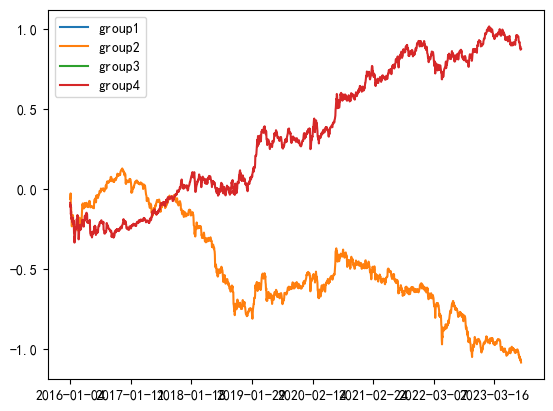

In [1940]:
# 分组收益率
gr_CP = xy.cal_rate_group(
    _sign.shift(1).T.loc[['50','1000'],'2016-01-04':],
    # _sigma.T.rolling(1).mean().shift(0).T.loc[['50','1000'],'2016-01-04':],
    xy.Index_rets.loc[['50','1000'],'2016-01-04':],
    group_num=4,
    masks=1
)
gr_CP.cumsum().plot()

1054.0
yoy: 0.22935101191501828 
 mdd: -0.19960926432217752 
 sharpe: 1.1859598938458038 
 rankIC: 0.08812260536398464 
 rankIR: 0.08844255908328423 
 win%: 0.5220193340494093 
 gain_loss%: -1.083092722008504


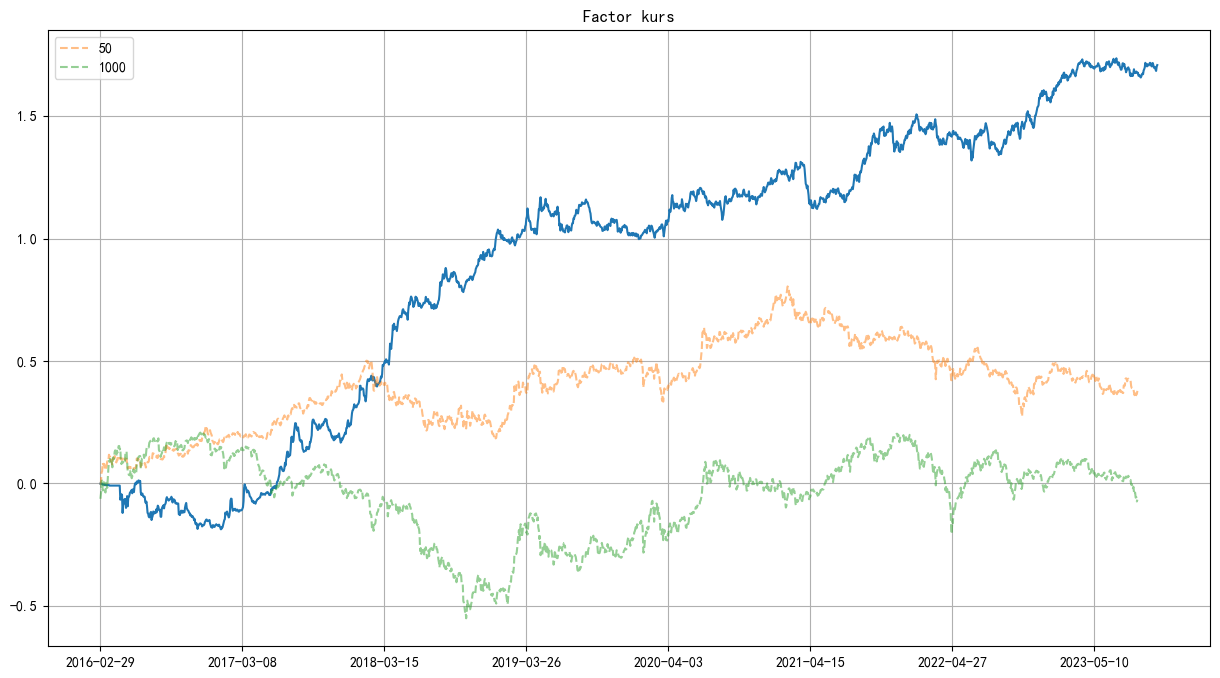

In [1963]:
# 单因子强弱
KURScount_select, KURScount_rets = xy.single_Factor_backtest(
    # _sign.rolling(1).mean().shift(1).T.loc[['50','1000'],'2016-01-04':],
    _sigma.T.rolling(2).mean().shift(0).T.loc[['50','1000'],'2016-01-04':],
    xy.Index_rets.loc[['50','1000'],'2016-02-28':],
    _side=1,
    fee=0.0005,
    name='kurs'
)

shrh: [-1.0, -0.91] win%: 0.5037593984962406 gainloss%: -1.0069491035110432
shrh: [-0.8, -0.71] win%: 0.5037593984962406 gainloss%: -1.0069491035110432
shrh: [-0.6, -0.51] win%: 0.5032397408207343 gainloss%: -1.004980442112286
shrh: [-0.4, -0.31] win%: 0.5005656108597285 gainloss%: -0.992728038989483
shrh: [-0.2, -0.11] win%: 0.4993342210386152 gainloss%: -1.001522731135206
shrh: [0.0, 0.09] win%: 0.500467726847521 gainloss%: -1.0383658390950115
shrh: [0.2, 0.29] win%: 0.484297520661157 gainloss%: -1.0301388151761839
shrh: [0.4, 0.49] win%: 0.5306122448979592 gainloss%: -1.0926505302119531
shrh: [0.6, 0.69] win%: 0.59375 gainloss%: -0.6682093551131851
shrh: [0.8, 0.89] win%: 0.7272727272727273 gainloss%: -0.5117002189460435


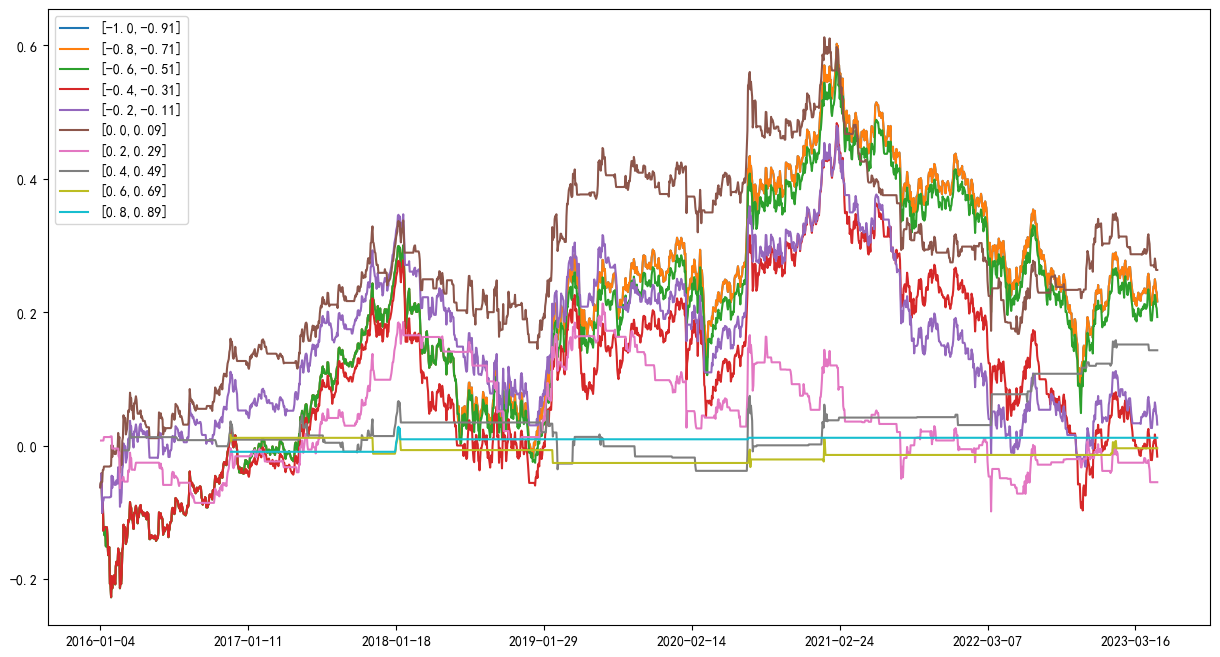

In [1713]:
idx_name = '50'

for i,j in zip(range(-100,100)[::20],range(-100,100)[9::20]):
    i = i / 100
    j = j / 100
    same_dt = set(((xy.Index_rets.loc[idx_name,'2016-01-04':] - 1)).T.index) & set(_sigma.T.rolling(1,min_periods=1).mean().shift(0).T.loc[idx_name].dropna().index)
    ts_ret = ((xy.Index_rets.loc[idx_name,'2016-01-04':] )).T.loc[_sigma.T.rolling(1,min_periods=1).mean().shift(0).T.loc[idx_name][(_sigma.T.rolling(1,min_periods=1).mean().shift(0).T.loc[idx_name]>i) ].index&same_dt].sort_index()
    
    
    # if abs(i) < 60:
    #     continue
    if ts_ret.shape[0] == 0:
        continue
    win_pct = ts_ret[ts_ret>0].shape[0]/ts_ret.shape[0]
    win_loss_ratio = ts_ret[ts_ret>0].mean()/ts_ret[ts_ret<0].mean()
    
    print('shrh:',[i,j], 'win%:', win_pct,'gainloss%:', win_loss_ratio)
    
    pd.Series(ts_ret.cumsum().rename(f'[{i},{j}]'),((xy.op.loc[:,'2016-01-04':]/xy.pcl.loc[:,'2016-01-04':] - 1)).T[idx_name].index).ffill().plot(legend=True,figsize=(15,8))

In [134]:
iCP_intraday50 = index_CP_intraday(xy.IndexMin50jq.close.dropna(), xy.IndexMin50jq.money.dropna(), 0.8)
iCP_intraday300 = index_CP_intraday(xy.IndexMin300jq.close.dropna(), xy.IndexMin300jq.money.dropna(), 0.8)
iCP_intraday500 = index_CP_intraday(xy.IndexMin500jq.close.dropna(), xy.IndexMin500jq.money.dropna(), 0.8)
iCP_intraday1000 = index_CP_intraday(xy.IndexMin1000jq.close.dropna(), xy.IndexMin1000jq.money.dropna(), 0.8)
# 参数平滑
iCP_intraday1 = pd.concat([
    iCP_intraday50.rename('50'),
    iCP_intraday300.rename('300'),
    iCP_intraday500.rename('500'),
    iCP_intraday1000.rename('1000'),
],axis=1).rolling(1).mean()

iCP_intraday4 = pd.concat([
    iCP_intraday50.rename('50'),
    iCP_intraday300.rename('300'),
    iCP_intraday500.rename('500'),
    iCP_intraday1000.rename('1000'),
],axis=1).rolling(4).mean().shift(1)

iCP_intraday5 = pd.concat([
    iCP_intraday50.rename('50'),
    iCP_intraday300.rename('300'),
    iCP_intraday500.rename('500'),
    iCP_intraday1000.rename('1000'),
],axis=1).rolling(5).mean().shift(1)

iCP_intraday6 = pd.concat([
    iCP_intraday50.rename('50'),
    iCP_intraday300.rename('300'),
    iCP_intraday500.rename('500'),
    iCP_intraday1000.rename('1000'),
],axis=1).rolling(6).mean().shift(1)

iCP_intraday = (iCP_intraday4 + iCP_intraday5 + iCP_intraday6) / 3

NameError: name 'index_CP_intraday' is not defined

In [ ]:
_sigma.T.rolling(1,min_periods=1).mean().shift(0).T.loc[['50','300','500', '1000'],'2016-01-04':].to_csv('../NewFactor/idx_STV.csv')